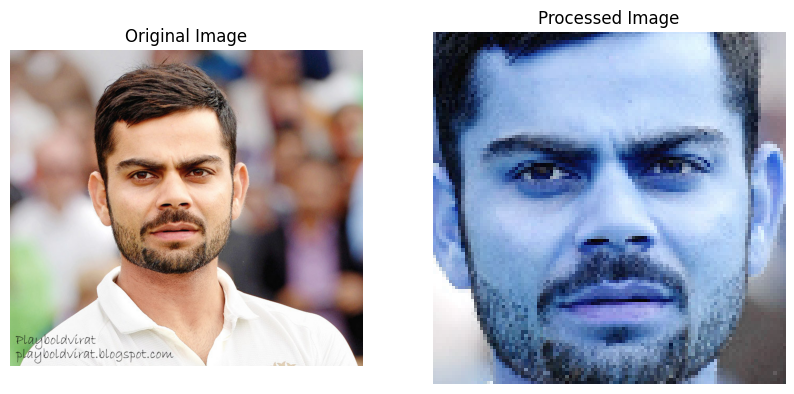

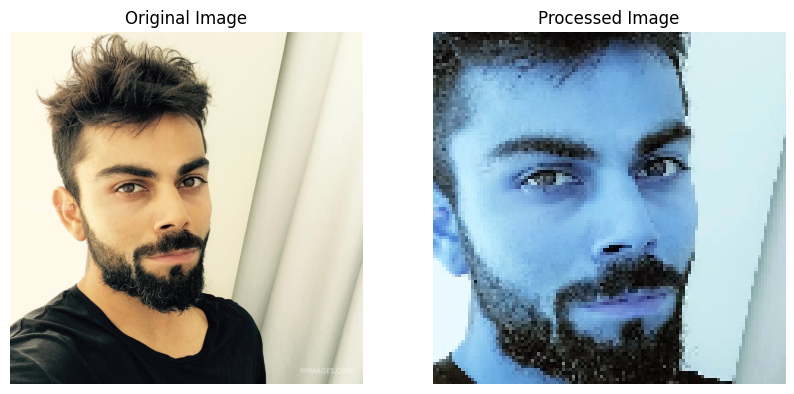

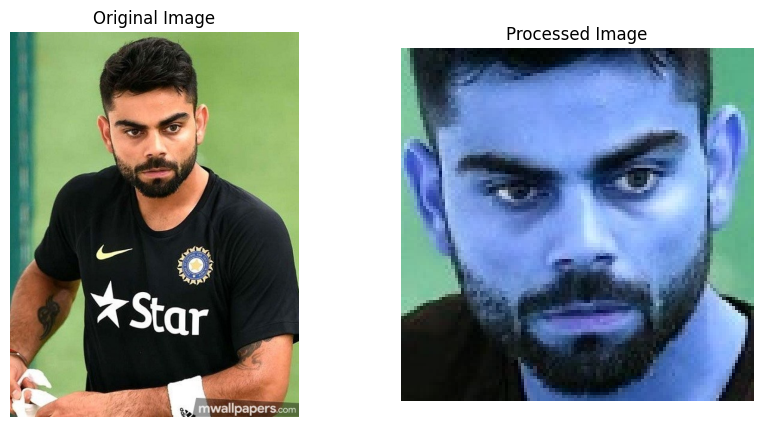

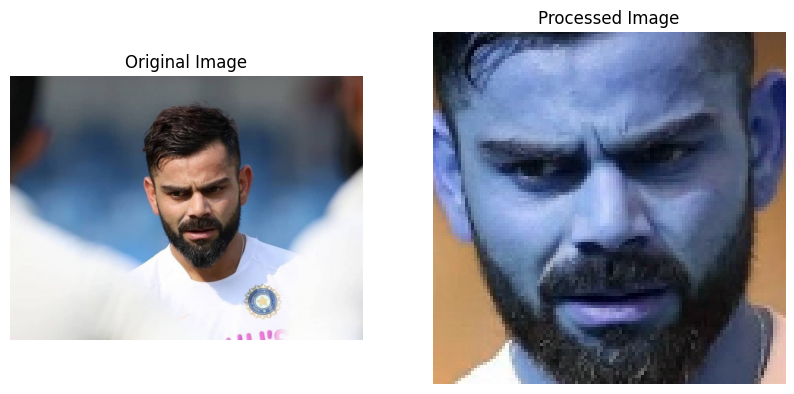

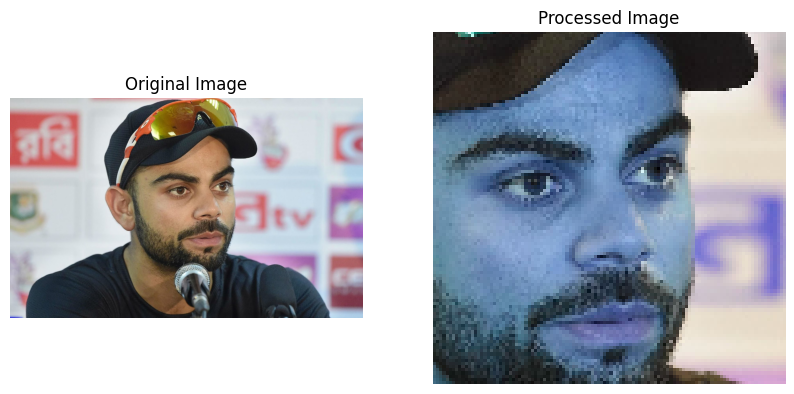

No face detected in siamese_face_dataset\User_29\Tiger_Woods_0010.jpg. Skipping.
No face detected in siamese_face_dataset\User_48\Yasser_Arafat_0004.jpg. Skipping.
No face detected in siamese_face_dataset\User_48\Yasser_Arafat_0007.jpg. Skipping.


In [5]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve
import os
import numpy as np
import matplotlib.pyplot as plt

# Load Haar Cascade for face detection
haar_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_cascade_path)

# Function to detect and crop face
def detect_and_crop_face(image_path, target_size=(112, 112)):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print(f"No face detected in {image_path}. Skipping.")
        return None

    # Crop the first detected face
    x, y, w, h = faces[0]
    cropped_face = img[y:y+h, x:x+w]
    cropped_face = cv2.resize(cropped_face, target_size)
    cropped_face = cropped_face / 255.0  # Normalize
    return cropped_face

# Function to visualize an image before and after preprocessing
def visualize_preprocessing(image_path, processed_image):
    # Read the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

    # Plot original and processed image
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Processed image
    plt.subplot(1, 2, 2)
    if processed_image is not None:
        plt.imshow(processed_image)
        plt.title("Processed Image")
        plt.axis("off")
    else:
        plt.text(0.5, 0.5, "No Face Detected", fontsize=12, ha='center', va='center')
        plt.axis("off")

    plt.show()

# Modify `load_dataset` to include visualization for a few images
def load_dataset_with_visualization(dataset_path, img_size, visualize=False, num_visualizations=5):
    data = []
    labels = []
    class_names = os.listdir(dataset_path)
    visualization_count = 0

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            cropped_face = detect_and_crop_face(img_path, target_size=(img_size, img_size))
            if cropped_face is not None:
                data.append(cropped_face)
                labels.append(label)

                # Visualize a few examples
                if visualize and visualization_count < num_visualizations:
                    visualize_preprocessing(img_path, cropped_face)
                    visualization_count += 1
    return np.array(data), np.array(labels), class_names



# Split dataset by identity
def split_dataset_by_identity(data, labels, test_size=0.2):
    train_data, train_labels, test_data, test_labels = [], [], [], []

    for label in np.unique(labels):
        idx = np.where(labels == label)[0]
        label_data = data[idx]
        label_labels = labels[idx]
        split_idx = int(len(label_data) * (1 - test_size))

        train_data.extend(label_data[:split_idx])
        train_labels.extend(label_labels[:split_idx])
        test_data.extend(label_data[split_idx:])
        test_labels.extend(label_labels[split_idx:])

    return (
        np.array(train_data), np.array(test_data),
        np.array(train_labels), np.array(test_labels)
    )

# Paths and parameters
dataset_path = "siamese_face_dataset"
model_path = "ArcFace-Res50.h5"
img_size = 112
batch_size = 8
epochs = 30

# Load and preprocess data
# Use the updated function to load the dataset
data, labels, class_names = load_dataset_with_visualization(
    dataset_path, img_size, visualize=True, num_visualizations=5
)
train_data, test_data, train_labels, test_labels = split_dataset_by_identity(data, labels, test_size=0.2)

In [2]:

# Convert labels to one-hot encoding
num_classes = len(class_names)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

# Load the pre-trained ArcFace model
model = load_model(model_path, compile=False)

# Add a new classification head
x = model.output
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

# Create a new model
new_model = tf.keras.models.Model(inputs=model.input, outputs=out)

# Freeze the base model layers
for layer in model.layers:
    layer.trainable = False

# Compile the model
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
train_generator = datagen.flow(train_data, train_labels, batch_size=batch_size)

# Train the model
history = new_model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=100,
    validation_data=(test_data, test_labels)
)

# Evaluate the model
predictions = new_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Precision, Recall, F1-Score
precision = precision_score(true_classes, predicted_classes, average="weighted")
recall = recall_score(true_classes, predicted_classes, average="weighted")
f1 = f1_score(true_classes, predicted_classes, average="weighted")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Compute EER
def calculate_eer(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

y_true_binary = (true_classes == predicted_classes).astype(int)
eer = calculate_eer(y_true_binary, predictions.max(axis=1))
print(f"EER: {eer}")

# Save the fine-tuned model
new_model.save("fine_tuned_arcface_model_with_haar.h5")

Epoch 1/100
37/37 [==============================] - 9s 190ms/step - loss: 6.2529 - accuracy: 0.0379 - val_loss: 5.8696 - val_accuracy: 0.0800
Epoch 2/100
37/37 [==============================] - 7s 198ms/step - loss: 5.7466 - accuracy: 0.0448 - val_loss: 5.5001 - val_accuracy: 0.1100
Epoch 3/100
37/37 [==============================] - 8s 216ms/step - loss: 5.6265 - accuracy: 0.0552 - val_loss: 5.0964 - val_accuracy: 0.1500
Epoch 4/100
37/37 [==============================] - 8s 223ms/step - loss: 5.6267 - accuracy: 0.0621 - val_loss: 4.7590 - val_accuracy: 0.1800
Epoch 5/100
37/37 [==============================] - 8s 220ms/step - loss: 5.3866 - accuracy: 0.0621 - val_loss: 4.4420 - val_accuracy: 0.3000
Epoch 6/100
37/37 [==============================] - 8s 223ms/step - loss: 5.2476 - accuracy: 0.0828 - val_loss: 4.1290 - val_accuracy: 0.3900
Epoch 7/100
37/37 [==============================] - 8s 222ms/step - loss: 5.0909 - accuracy: 0.0966 - val_loss: 3.8901 - val_accuracy: 0.4400

c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

4/4 [==============================] - 1s 320ms/step
Classification Report:
              precision    recall  f1-score   support

      User_1       1.00      1.00      1.00         2
     User_10       1.00      1.00      1.00         2
     User_11       1.00      0.50      0.67         2
     User_12       1.00      1.00      1.00         2
     User_13       1.00      1.00      1.00         2
     User_14       1.00      1.00      1.00         2
     User_15       1.00      1.00      1.00         2
     User_16       1.00      1.00      1.00         2
     User_17       1.00      1.00      1.00         2
     User_18       1.00      1.00      1.00         2
     User_19       1.00      1.00      1.00         2
      User_2       1.00      1.00      1.00         2
     User_20       1.00      1.00      1.00         2
     User_21       1.00      0.50      0.67         2
     User_22       1.00      0.50      0.67         2
     User_23       1.00      1.00      1.00         2
     

c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

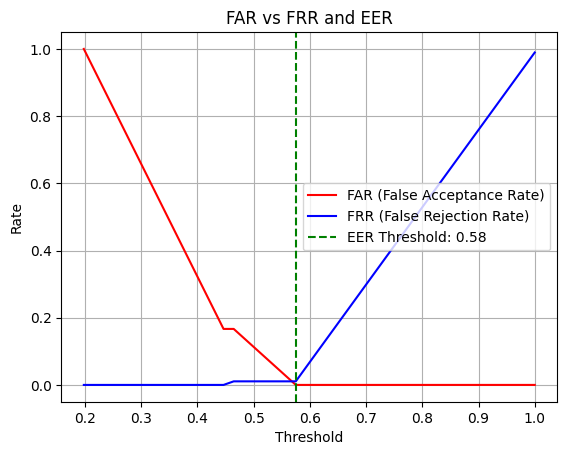

EER: 0.0


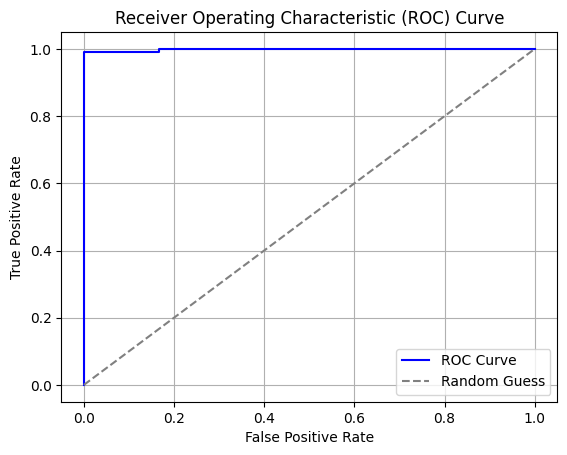

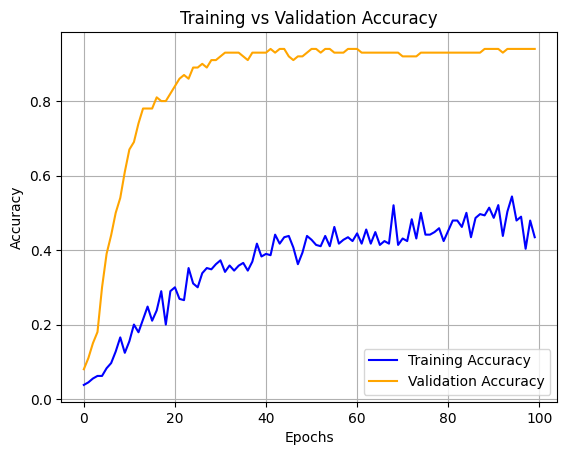

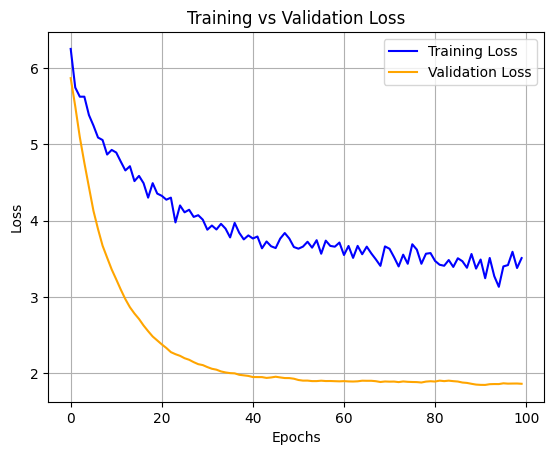

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Evaluate the model
predictions = new_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Precision, Recall, F1-Score
precision = precision_score(true_classes, predicted_classes, average="weighted")
recall = recall_score(true_classes, predicted_classes, average="weighted")
f1 = f1_score(true_classes, predicted_classes, average="weighted")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Compute EER and plot FAR vs FRR
def calculate_eer(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]

    # Plot FAR vs FRR
    plt.figure()
    plt.plot(thresholds, fpr, label='FAR (False Acceptance Rate)', color='red')
    plt.plot(thresholds, fnr, label='FRR (False Rejection Rate)', color='blue')
    plt.axvline(x=eer_threshold, color='green', linestyle='--', label=f'EER Threshold: {eer_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title('FAR vs FRR and EER')
    plt.legend()
    plt.grid()
    plt.show()

    return eer

y_true_binary = (true_classes == predicted_classes).astype(int)
eer = calculate_eer(y_true_binary, predictions.max(axis=1))
print(f"EER: {eer}")

# Plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curve(y_true_binary, predictions.max(axis=1))

# Plot training vs validation graph
def plot_train_val_graph(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming `history` is the training history object
plot_train_val_graph(history)


In [6]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf

# Paths and parameters
model_path = "fine_tuned_arcface_model_with_haar.h5"

# Load the trained model
model = load_model(model_path, compile=False)

# Extract feature embeddings from the penultimate layer
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Generate embeddings for training data
def generate_train_embeddings(train_data, train_labels, class_names, feature_extractor):
    embeddings = {}
    for label in np.unique(train_labels):
        class_indices = np.where(train_labels == label)[0]
        class_embeddings = []
        for idx in class_indices:
            embedding = feature_extractor.predict(np.expand_dims(train_data[idx], axis=0))
            class_embeddings.append(embedding)
        embeddings[class_names[label]] = np.mean(class_embeddings, axis=0)
    return embeddings

train_embeddings = generate_train_embeddings(train_data, train_labels, class_names, feature_extractor)

# Save embeddings
np.save("face_embeddings.npy", train_embeddings)
print("Training embeddings saved.")


1/1 [==============================] - 0s 59ms/step
Training embeddings saved.
